In [1]:
import pandas as pd
import gender_guesser.detector as gender
import numpy as np
from rdrobust import rdrobust,rdplot

from rdd import rdd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import scipy.stats
#For Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
from binsreg import *
import urllib.request

In [2]:
'''Import Data'''
df = pd.read_csv(r"C:\Users\d0tam\iCloudDrive\Desktop\Data\test.csv")



C:\Users\d0tam\AppData\Local\Temp\ipykernel_25728\3274978501.py:2: DtypeWarning: Columns (17,18) have mixed types. Specify dtype option on import or set low_memory=False.


In [3]:
'''Useful Functions and Mappings'''

currency_to_id = {currency: idx for idx, currency in enumerate(df['currency'].unique())}


In [4]:

#Get probability weights
def probability_weights(x, y):
    test = pd.read_stata(r"C:\Users\d0tam\iCloudDrive\Desktop\PhD\Research\Kickstarter\Robustness\Data\ICPSR_38050\DS0001\38050-0001-Data.dta")

    '''Clean ICPSR Data'''
    def convert_dollar_to_float(dollar_str):
        # Remove commas and dollar sign, then convert to float
        return float(dollar_str.replace('$', '').replace(',', ''))

    # Applying the conversion function to the 'dollar_amount' column
    test['GOAL_IN_USD'] = test['GOAL_IN_USD'].apply(convert_dollar_to_float)
    test['PLEDGED_IN_USD'] = test['PLEDGED_IN_USD'].apply(convert_dollar_to_float)

    #Date Clean
    test['LAUNCHED_DATE'] = pd.to_datetime(test['LAUNCHED_DATE'])
    test['DEADLINE_DATE'] = pd.to_datetime(test['DEADLINE_DATE'])


    #Sort
    test = test.sort_values(by = ['UID','LAUNCHED_DATE']).reset_index(drop = True)


    #Generate Regression Variables
    test['first_kickstarter'] = test.groupby('UID').cumcount() == 0
    test['first_kickstarter'] = test['first_kickstarter'].astype(int)



    test['campaign_duration'] = (test['DEADLINE_DATE'] - test['LAUNCHED_DATE']).dt.days
    test['year_of_launch'] = test['LAUNCHED_DATE'].dt.year



    test['currency.id'] = test['PROJECT_CURRENCY'].map(currency_to_id)

    
    test = test.rename(columns = {'CATEGORY_ID':'category.id',
                    'year_of_launch':'year',
                    'GOAL_IN_USD':'goal',
                    'PLEDGED_IN_USD':'pledged',
                    'BACKERS_COUNT':'backers_count'})    
        
    test['backers_count'] = test['backers_count'].replace(np.nan, 0)
    X = test[x]

    Y = test[y].to_numpy().ravel()
    


    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X)


    # Train a Logistic Regression model
    logit_model = LogisticRegression()
    logit_model.fit(X_train_scaled, Y)
    
    X_test = df[x]
    X_test_scaled = scaler.transform(X_test)
    y_probs = logit_model.predict_proba(X_test_scaled)[:, 1]  # Probabilities of class 1 (successful)

    
    return y_probs




In [5]:

# Define the states you want to keep
valid_states = ['successful', 'failed', 'canceled']

# Filter the DataFrame to keep only the valid states
df = df[df['state'].isin(valid_states)]

# Drop duplicates based on specific columns
columns_to_check_duplicates = ['id', 'creator.id', 'goal', 'deadline']
df = df.drop_duplicates(subset=columns_to_check_duplicates)

'''Date Cleaning'''
# Convert date columns to datetime
date_columns = ['deadline', 'created_at', 'launched_at']
df[date_columns] = df[date_columns].apply(pd.to_datetime, unit='s')



In [6]:

'''Sort'''
df = df.sort_values(by=['creator.id', 'created_at']).reset_index(drop=True)


'''Get Success Information'''
df_duplicates_first_dropped = df[~(df['creator.id'].duplicated(keep=False) ^ df['creator.id'].duplicated())]
df_duplicates_first_dropped['success'] = np.where((df_duplicates_first_dropped['pledged'] > df_duplicates_first_dropped['goal']) & (df_duplicates_first_dropped['state'] == 'successful'), 1, 0)
grouped = df_duplicates_first_dropped.groupby('creator.id', as_index = False).agg({'success':'sum', 'creator.name':'count'})
grouped['creator.name'] = grouped['creator.name']

grouped2 = df_duplicates_first_dropped.groupby(['creator.id','success'], as_index = False).agg({'pledged':'sum'})
grouped2 = grouped2[grouped2['success'] == 1]
grouped2 = grouped2[['creator.id', 'pledged']]
del df_duplicates_first_dropped



df = pd.merge(df, grouped, left_on = 'creator.id', right_on = 'creator.id', how = 'left', suffixes=['', '_x'])
df = pd.merge(df, grouped2, left_on = 'creator.id', right_on = 'creator.id', how = 'left', suffixes=['', '_y'])
df['success_rate_after'] = df['success']/(df['creator.name_x'])
df['success_ever'] = np.where(df['success'] > 0, 1, 0)
df = df.rename(columns = {'success':'total_success', 'creator.name_x':'total_kickstarters', 'pledged_y':'total_raised_after'})

del grouped, grouped2

C:\Users\d0tam\AppData\Local\Temp\ipykernel_25728\4036975276.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:


df['contribution'] = df['pledged']/df['goal']
df['dollar_difference'] = df['pledged'] - df['goal']
df['contribution'] = df['contribution'].replace(np.nan, 0)
df['total_raised_after'] = df['total_raised_after'].replace(np.nan, 0)
df['campaign_duration'] = (df['deadline'] - df['launched_at']).dt.days

#Keep only the first kickstarter
df = df.drop_duplicates(subset = 'creator.id', keep = 'first')



#Remove Outliers
df = df[(df['dollar_difference'] > -100000) & (df['dollar_difference'] < 100000)]


In [8]:



'''Add Creator & Gender Information'''
gd = gender.Detector()
df['first_name'] = df['creator.name'].str.split(pat = ' ', n = 0, expand = True)[0]
df['first_name'] = df['first_name'].astype(str)
df['gender'] = df['first_name'].apply(str.capitalize).map(lambda x: gd.get_gender(x))






In [9]:




'''Generate Variables for Regression'''
df['year'] = df['deadline'].dt.year
df['year'] = df['year'].astype(str)
#df['staff_pick'] = np.where(df['staff_pick'] == True, 1, 0)


df['contribution'] = df['contribution'].astype(float)
df['total_success'] = df['total_success'].astype(int)


In [10]:


#Apply Currency id
df['currency.id'] = df['currency'].map(currency_to_id)

df = df.reset_index(drop = True)

#Generate Few Important Variables
df['male'] = 0
df['male'][df['gender'] == 'male'] = 1
df['female'] = 0
df['female'][df['gender'] == 'female'] = 1
df['company'] = 0
df.loc[(df['gender'] != 'male') & (df['gender'] != 'female') & (df['gender'] != 'mostly_male') & (df['gender'] != 'mostly_female') & (df['gender'] != 'andy'), 'company'] = 1
df['us'] = 0
df.loc[df['location.country'] == 'US', 'us'] = 1


C:\Users\d0tam\AppData\Local\Temp\ipykernel_25728\923344293.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\d0tam\AppData\Local\Temp\ipykernel_25728\923344293.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of

Text(0.5, 1.0, 'Distribution of Entrepreneurs near Cutoff')

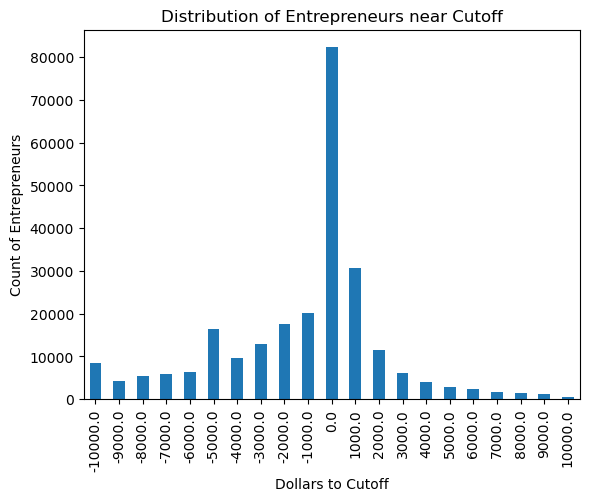

In [11]:
df1 = df[(df['dollar_difference'] > -10000) & (df['dollar_difference'] < 10000)]

plt.figure()
df1.round({"dollar_difference":-3}).groupby("dollar_difference").size().plot.bar()
plt.xlabel('Dollars to Cutoff')
plt.ylabel('Count of Entrepreneurs')
plt.title('Distribution of Entrepreneurs near Cutoff')

In [12]:
df['treat'] = 0
df['treat'].loc[df['dollar_difference'] >= 0] = 1
gender = df.groupby(['gender', 'treat'], as_index = False).agg({'us':'mean',
                                                                'dollar_difference':'mean',
                                                                'goal':'mean',
                                                                'pledged':'mean',
                                                                'backers_count':'mean',
                                                                'id':'count'})
fail = gender[gender['treat'] == 0].reset_index(drop = True)
passed = gender[gender['treat'] == 1].reset_index(drop = True)

gender = pd.concat([fail, passed], axis = 0)
gender = gender.drop('treat', axis = 1)
gender = gender.round(2)
gender = gender.rename(columns = {'id':'Obs.',
                                  'us':'US Campaigns',
                                  'dollar_difference':'Dollars To Cutoff',
                                  'goal':'Goal',
                                  'pledged':'Amount Pledged',
                                  'backers_count':'Backers'})

gender = gender.round(decimals=2).astype(str)
print(gender.to_latex(index = False))


\begin{tabular}{lllllll}
\toprule
gender & US Campaigns & Dollars To Cutoff & Goal & Amount Pledged & Backers & Obs. \\
\midrule
andy & 0.73 & -13643.02 & 14802.13 & 1159.11 & 13.48 & 1879 \\
female & 0.74 & -11685.68 & 12636.12 & 950.44 & 11.92 & 31479 \\
male & 0.73 & -14781.22 & 15698.49 & 917.27 & 11.87 & 89921 \\
mostly_female & 0.8 & -12598.46 & 13775.31 & 1176.85 & 14.33 & 6203 \\
mostly_male & 0.78 & -13623.6 & 14580.35 & 956.75 & 12.05 & 8423 \\
unknown & 0.7 & -15568.53 & 17295.21 & 1726.68 & 19.92 & 50465 \\
andy & 0.69 & 3728.57 & 8183.02 & 11911.58 & 143.52 & 1755 \\
female & 0.71 & 2144.59 & 7689.7 & 9834.29 & 110.3 & 30655 \\
male & 0.74 & 3387.9 & 8599.19 & 11987.09 & 142.14 & 51532 \\
mostly_female & 0.79 & 2788.96 & 8544.68 & 11333.65 & 135.39 & 6902 \\
mostly_male & 0.79 & 3027.29 & 7127.04 & 10154.32 & 139.1 & 5615 \\
unknown & 0.66 & 6335.68 & 12406.96 & 18742.63 & 204.75 & 48642 \\
\bottomrule
\end{tabular}



C:\Users\d0tam\AppData\Local\Temp\ipykernel_25728\4018596505.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\d0tam\AppData\Local\Temp\ipykernel_25728\4018596505.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy 

In [13]:

df['first_kickstarter'] = 1

x = ['category.id', 'currency.id', 'campaign_duration','year', 'goal', 'pledged', 'backers_count']
y =  ['first_kickstarter']
df['weights'] = probability_weights(x,y)



In [14]:
'''Statistics Balance'''

#df_female_1 = df.query("female == 1 & dollar_difference > 0")
#df_male_0 =  df.query("male == 1 & dollar_difference < 0")
#df = pd.concat([df_female_1, df_male_0], axis = 0)

statistics = df.sort_values(by = 'dollar_difference', ignore_index = True)
l=statistics[statistics.dollar_difference<0].dollar_difference.count()
statistics = statistics[['us', 'company', 'male', 'female', 'campaign_duration', 'pledged','goal','weights']]
statistics = statistics.drop(columns=['weights']).mul(statistics['weights'], axis=0)
left = statistics[0:l]
right = statistics[l:]


results = pd.DataFrame(columns = ['N', 'Mean', 'Std. Dev.', 'N ', 'Mean ', 'Std. Dev. ', 'RD Effect', 'Robust p-val'])

stat_left_mean = left.mean().round(2)
stat_left_std = left.std().round(2)
stat_left_count = left.count()

stat_right_mean = right.mean().round(2)
stat_right_std = right.std().round(2)
stat_right_count = right.count()


results['N'] = stat_left_count
results['Mean'] = stat_left_mean
results['Std. Dev.'] = stat_left_std

results['N '] = stat_right_count
results['Mean '] = stat_right_mean
results['Std. Dev. '] = stat_right_std


In [15]:

'''Covariate Balance'''

for z in statistics.columns:
    est = rdrobust(y=statistics[z], x=df['dollar_difference'], c = 0, kernel = "epanechnikov", h = [500,500], p = 1)
    results.loc[z,"RD Effect"] = est.t["t-stat."]['Conventional']
    results.loc[z,"Robust p-val"] = est.pv.iloc[0].values[0]

del stat_left_mean, stat_left_std, stat_left_count, stat_right_mean,stat_right_std,stat_right_count,left,right

print(est)

results['RD Effect'] = round(results['RD Effect'].astype(float),2)
results['Robust p-val'] = round(results['Robust p-val'].astype(float),2)

results = results.round(decimals=2).astype(str)
print(results.to_latex())


Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Call: rdrobust
Number of Observations:                333471
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                          Epanechnikov
Bandwidth Selection:                   Manual
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations        188370     145101
Number of Unique Obs.          40789      40942
Number of Effective Obs.       11562      69211
Bandwidth Estimation             500        500
Bandwidth Bias                   500        500
rho (h/b)                        1.0        1.0



In [16]:
#Regression
df = df.reset_index(drop = True)
x = df['dollar_difference']
y = df['total_kickstarters']
#y = df['total_kickstarters']
weights = df['weights']


covs = df[['campaign_duration', 'us', 'category.id']]
covs = pd.concat([covs,pd.get_dummies(covs['category.id'], prefix = 'cat',drop_first = True)], axis = 1)
covs = covs.replace(np.nan, 'unknown')
covs = covs.squeeze()
covs = covs.replace({False: 0, True: 1})


threshold = 0
bandwidth_opt = rdd.optimal_bandwidth(y, x, cut=threshold)


C:\Users\d0tam\AppData\Local\Temp\ipykernel_25728\2138675272.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


In [17]:
print(rdrobust(y=y, x=x, c = 0, all=True, kernel = "triangular", h = [10000,10000], p = 1))
#print(rdrobust(y=y, x=x, c = 0, all=True, kernel = "epanechnikov", p = 1))
#print(rdrobust(y=y, x=x, c = 0, all=True, kernel = "epanechnikov", h = [bandwidth_opt,bandwidth_opt], p = 1))
#print(rdrobust(y=y, x=x, c = 0, all=True, kernel = "epanechnikov", h = [500,500], p = 1, covs = covs, covs_drop = False))
#print(rdrobust(y=y, x=x, c = 0, all=True, kernel = "epanechnikov", h = [-1000,1000], p = 1, weights=weights))


Mass points detected in the running variable.
Call: rdrobust
Number of Observations:                333471
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                   Manual
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations        188370     145101
Number of Unique Obs.          40789      40942
Number of Effective Obs.      119941     131423
Bandwidth Estimation           10000      10000
Bandwidth Bias                 10000      10000
rho (h/b)                        1.0        1.0

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       0.043    0.006    7.049   1.803e-12     [0.031, 0.055]
Bias-Corrected     0.021    0.006    3.468   5.251e-04   

# Figures

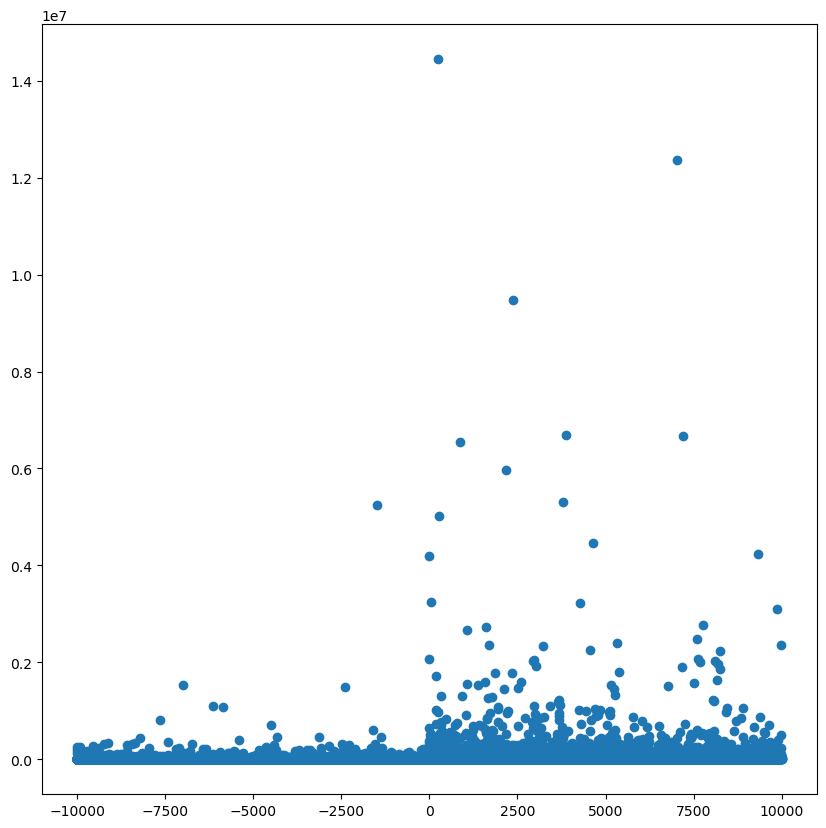

In [19]:
plot_data = df[(df['dollar_difference'] > -10000) & (df['dollar_difference'] < 10000)]
plot_data = plot_data.groupby([''])
plt.figure(figsize = (10,10))
plt.scatter(plot_data['dollar_difference'], plot_data['total_raised_after'])